### Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf

# Int cufflinks
# making all charts public and setting a global theme
cf.set_config_file(theme='solar',offline=True)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set matplotlib in Darkmode
plt.style.use('dark_background')

### 01. Load the Dataset

In [2]:
def load_dataset(path:str) -> pd:
    return pd.read_csv(path)

In [3]:
# Loading data using pandas
path = './diabetes.csv'
dataset = load_dataset(path)
columns = list(dataset.columns)

### 02. Explorethe Dataset

In [4]:
# Explore the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# Shows if there are any entries that are NA or NAN
dataset.isna().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [6]:
#Plotting data
def plot_data(dataset):
    """Plot out all the data from the dataset in different histograms"""
    dataset.hist(bins=50, figsize = (20,15))
    plt.show()
    return


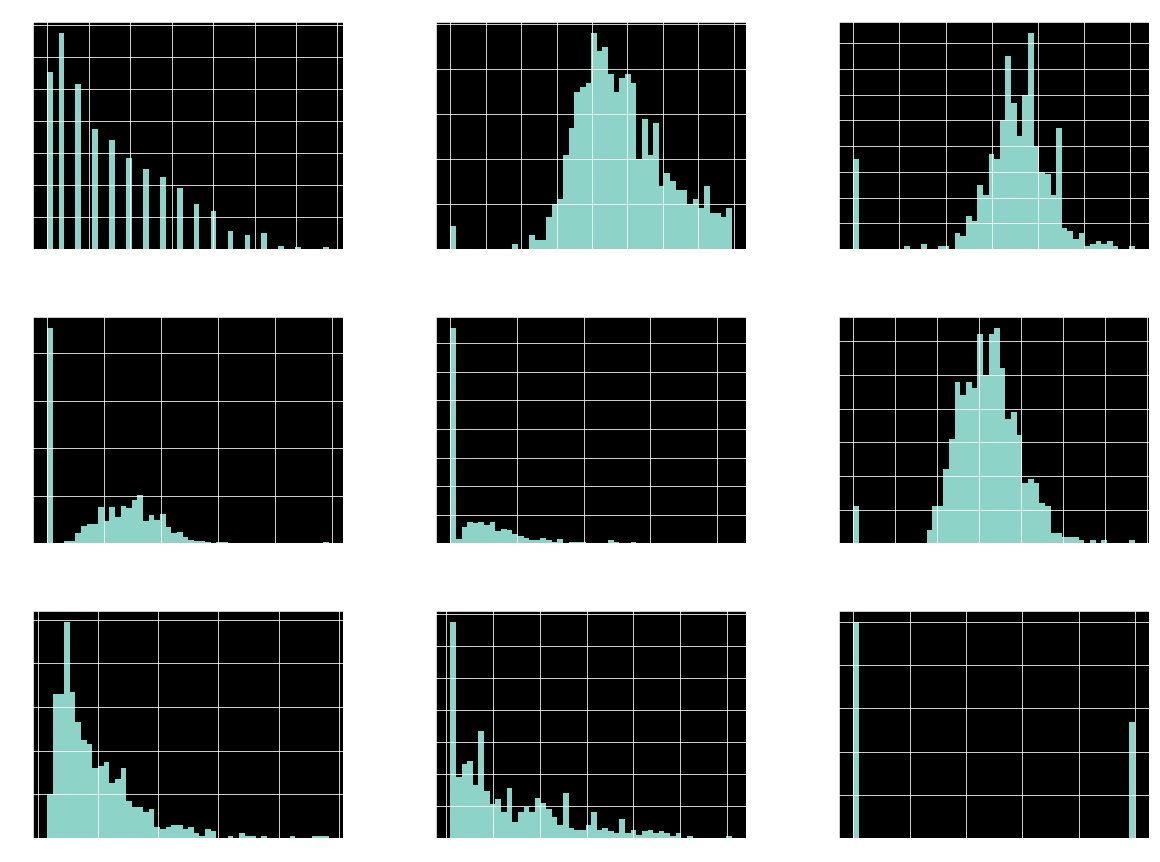

In [7]:
plot_data(dataset)

### 03. Correlation Matrix

<AxesSubplot:>

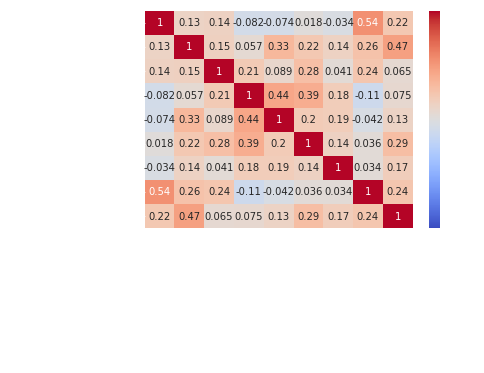

In [8]:
# Correlation data 
corr = dataset.corr()

# Correlation matrix with seaborn (correlation val are -1 to 1, thats why vmin vmax)
sns.heatmap(corr, vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')

No meaningful correlation found. All features are informative.

### Functions for Checking Parameters

In [9]:
from sklearn.metrics import roc_auc_score, roc_curve

# Check AOC ARC curve
def aoc_arc_curve(pred, labels_test):
    """Plots the AOC ARC curve and score"""
    auc = roc_auc_score(labels_test, pred)
    print('AUROC score: {:.2f}'.format(auc))

    false_positive_rate, true_positive_rate, thresolds = roc_curve(labels_test, pred)

    plt.figure(figsize=(5, 4), dpi=100)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("AUC & ROC Curve")
    plt.plot(false_positive_rate, true_positive_rate, 'y')
    
    plt.plot([0,1],[0,1], linestyle='dotted')

    plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightyellow', alpha=0.7)
    plt.text(0.95, 0.05, 'AUC = {:.2f}'.format(auc), ha='right', fontsize=12, weight='bold')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    
    return auc

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def parameter_check(pred, labels_test):
    """Determines accuracy, precision, recall, f1 and aoc arc curve"""
    # Check accuracy
    accuracy = accuracy_score(labels_test , pred)

    # Check precision
    precision = precision_score(labels_test , pred)

    # Check recall
    recall = recall_score(labels_test , pred)

    # Check F1 score
    F1 = f1_score( labels_test , pred)

    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1 score: {:.2f}'.format(F1))
    
    auc = aoc_arc_curve(pred, labels_test)
    
    return { 'accuracy': accuracy, 'precision':precision, 'recall':recall, 'fi':F1, 'auc': auc}


### 04 Data Pre-processing

In [11]:
from sklearn.model_selection import train_test_split

# Create features and labels
features = dataset.drop(['Outcome'], axis=1)
labels = dataset['Outcome']

# Create training (75%) and test (25%) sets
features_train, features_test , labels_train , labels_test = train_test_split(features, labels, test_size =0.25)


Scaling, Imputation and Balancing of the data don't seem to have a significant effect on the results.

### 05 Classifier

In [12]:
def run_classifier(classifier, features_train, labels_train, features_test, labels_test) -> dict:
    # Fit data for training into classifier
    classifier.fit(features_train , labels_train)
    # Predicting with classifier
    pred = classifier.predict(features_test)
    return parameter_check(pred, labels_test)

##  Pipeline

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

In [14]:
def build_pipeline(params, classifier, cv='skf'):
    # Setting up a pipeline
    pipe = Pipeline([
        ('scaler', None),
        ('imputer', None),
        ('upsampler', None),
        ('downsampler', None),
        ('clf', classifier)
    ])

    # Cross validation
    if cv == 'skf':
        skf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
    elif cv == 'rskf':
        skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    # Set up the grid search
    gs = GridSearchCV(pipe,params,n_jobs=-1,cv=skf,scoring='accuracy')

    # Fit gs to training data
    gs_results = gs.fit(features_train, labels_train)

    # Find best fit
    print(f'Best score: {gs_results.best_score_}')
    print(f'Best parameters: \n{gs_results.best_params_}')

    # Get score
    print(f'\nScore: {gs.score(features_test, labels_test)}')

    # Predict results
    labels_preds = gs.predict(features_test)
    best_par = parameter_check(labels_preds, labels_test)

    return best_par, gs_results


### KNN Classifier - Pipeline

Best score: 0.7726236881559221
Best parameters: 
{'clf__metric': 'minkowski', 'clf__n_neighbors': 7, 'clf__weights': 'uniform', 'downsampler': 'passthrough', 'imputer': SimpleImputer(missing_values=0), 'imputer__strategy': 'mean', 'scaler': MinMaxScaler(), 'upsampler': 'passthrough'}

Score: 0.7447916666666666
Accuracy: 0.74
Precision: 0.60
Recall: 0.69
F1 score: 0.64
AUROC score: 0.73


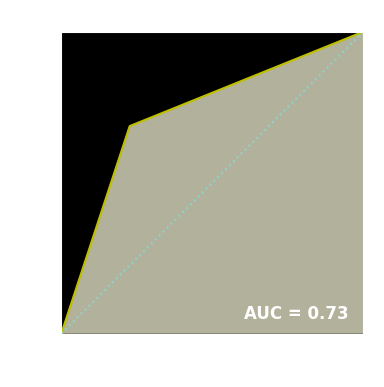

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from sklearn.impute import SimpleImputer

# Create KNN Classifier
classifier_knn = KNeighborsClassifier()

# Parameter grid to search over using grid search
params={
    'imputer': [SimpleImputer(missing_values=0)],
    'imputer__strategy': ['mean', 'median'],
    'downsampler':['passthrough',
                   RandomUnderSampler(random_state=42),
                   TomekLinks()
                  ],
    'upsampler': ['passthrough',
                  RandomOverSampler(random_state=42),
                  SMOTENC(categorical_features=[0], random_state=42, k_neighbors=0)
                 ],
    'scaler':[StandardScaler(), MinMaxScaler()],
    'clf__n_neighbors':[3,5,7,9,11,13],
    'clf__weights':['uniform', 'distance'],
    'clf__metric': ['minkowski', 'manhattan', 'euclidian']
}

best_par_knn, score_knn = build_pipeline(params,classifier_knn)

### SVM Classifier - Pipeline

In [ ]:
from sklearn.svm import SVC

# Create SVM Classifier
classifier_svm = SVC()

# Parameter grid to search over using grid search
params={
    'imputer': [SimpleImputer(missing_values=0)],
    'imputer__strategy': ['mean', 'median'],
    'upsampler': ['passthrough',
                  RandomOverSampler(random_state=42),
                  SMOTENC(categorical_features=[0], random_state=42, k_neighbors=0)
                 ],
    'downsampler':['passthrough',
                   RandomUnderSampler(random_state=42),
                   TomekLinks()
                  ],
    'scaler':[StandardScaler(), MinMaxScaler()],
    'clf__degree':[0.001, 0.01, 0.1, 1, 10],
    'clf__gamma' : [1,2,3,4,5]
    #'clf__kernel' :['rbf', 'linear', 'poly' ,'sigmoid']
}

In [ ]:
best_par_svm, score_svm = build_pipeline(params, classifier_svm)

### Logistic Regression - Pipeline

In [28]:
from sklearn.linear_model import LogisticRegression

# Create Logistic Regression Classifier
classifier_lr = LogisticRegression()

# Parameter grid to search over using grid search
params={
    'imputer': [SimpleImputer(missing_values=0)],
    'imputer__strategy': ['mean', 'median'],
    'upsampler': ['passthrough',
                  RandomOverSampler(random_state=42),
                  SMOTENC(categorical_features=[0], random_state=42, k_neighbors=0)
                 ],
    'downsampler':['passthrough',
                   RandomUnderSampler(random_state=42),
                   TomekLinks()
                  ],
    'scaler':[StandardScaler(), MinMaxScaler()],
    'clf__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag'],
    'clf__multi_class':['ovr', 'multinomial'],
    'clf__class_weight':['None', 'balanced']
}

Best score: 0.7743928035982008
Best parameters: 
{'clf__class_weight': 'None', 'clf__multi_class': 'ovr', 'clf__solver': 'newton-cg', 'downsampler': 'passthrough', 'imputer': SimpleImputer(missing_values=0), 'imputer__strategy': 'mean', 'scaler': StandardScaler(), 'upsampler': 'passthrough'}

Score: 0.75
Accuracy: 0.75
Precision: 0.64
Recall: 0.58
F1 score: 0.61
AUROC score: 0.71


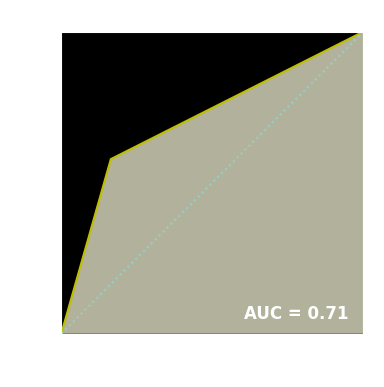

In [29]:
best_par_lr, score_lr = build_pipeline(params, classifier_lr)

### Random Forest Classifier - Pipeline

Best score: 0.7761019490254872
Best parameters: 
{'clf__max_depth': 30, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 3, 'clf__n_estimators': 50}

Score: 0.7395833333333334
Accuracy: 0.74
Precision: 0.61
Recall: 0.62
F1 score: 0.62
AUROC score: 0.71


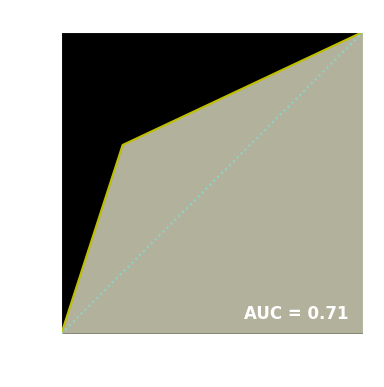

In [30]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest Classifier
classifier_rf = RandomForestClassifier(criterion='entropy')

# Parameter grid to search over using grid search
params={
    'clf__n_estimators':[10, 50, 100, 500],
    'clf__max_depth': [20,30,50],
    'clf__min_samples_split': [2,3,4],
    'clf__min_samples_leaf': [3,5]
}

best_par_rf, score_rf = build_pipeline(params, classifier_rf)


### AdaBoost Classifier - Pipeline

Best score: 0.7743778110944528
Best parameters: 
{'clf__learning_rate': 1.0, 'clf__n_estimators': 10}

Score: 0.71875
Accuracy: 0.72
Precision: 0.59
Recall: 0.53
F1 score: 0.56
AUROC score: 0.67


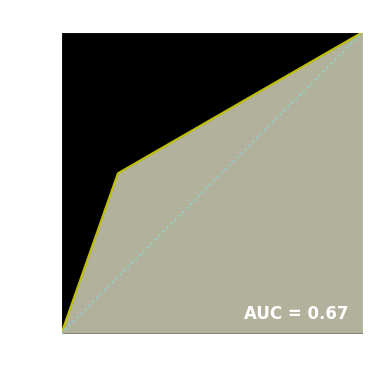

In [31]:
from sklearn.ensemble import AdaBoostClassifier

# Create AdaBoost Classifier
classifier_ada = AdaBoostClassifier()

# Parameter grid to search over using grid search
params={
    'clf__n_estimators':[10, 50, 100, 500],
    'clf__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]
}

best_par_ada, score_ada = build_pipeline(params, classifier_ada)

### GradientBoost Classifier - Pipeline

Best score: 0.7726386806596702
Best parameters: 
{'clf__learning_rate': 0.01, 'clf__max_depth': 1, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 500}

Score: 0.734375
Accuracy: 0.73
Precision: 0.62
Recall: 0.52
F1 score: 0.56
AUROC score: 0.68


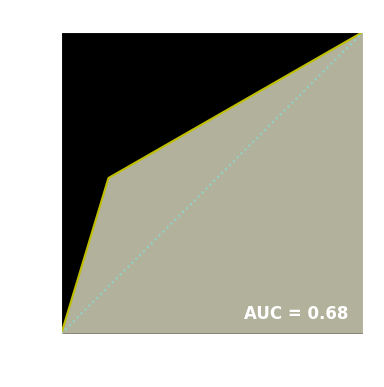

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

# Create GradientBoost Classifier
classifier_grad = GradientBoostingClassifier()

# Parameter grid to search over using grid search
params={
    'clf__n_estimators':[5,50,250,500],
    'clf__max_depth' : [1,3,5,7,9],
    'clf__learning_rate': [0.01,0.1,1,10,100],
    'clf__min_samples_split': [2,3,4],
    'clf__min_samples_leaf': [3,5]

}

best_par_grad, score_grad = build_pipeline(params, classifier_grad)



### Algorithm Comparison: Parameters

In [39]:
# Plot out different parameters
compare = [best_par_knn, best_par_svm, best_par_lr, best_par_rf, best_par_ada, best_par_grad ]
headers_comparison = [ 'KNN', 'SVM','Logistic Regression','RandomForest','AdaBoost', 'GradBoost']

In [64]:
compare_df = pd.DataFrame(compare)

compare_df

,accuracy,precision,recall,fi,auc
0,0.744792,0.602740,0.687500,0.642336,0.730469
1,0.791667,0.706897,0.640625,0.672131,0.753906
2,0.750000,0.637931,0.578125,0.606557,0.707031
3,0.739583,0.606061,0.625000,0.615385,0.710938
4,0.718750,0.586207,0.531250,0.557377,0.671875
5,0.734375,0.622642,0.515625,0.564103,0.679688


In [66]:
compare_df["results"]=headers_comparison
compare_df = compare_df.set_index('results', drop=True).rename_axis(None)
compare_df

,accuracy,precision,recall,fi,auc
KNN,0.744792,0.602740,0.687500,0.642336,0.730469
SVM,0.791667,0.706897,0.640625,0.672131,0.753906
Logistic Regression,0.750000,0.637931,0.578125,0.606557,0.707031
RandomForest,0.739583,0.606061,0.625000,0.615385,0.710938
AdaBoost,0.718750,0.586207,0.531250,0.557377,0.671875
GradBoost,0.734375,0.622642,0.515625,0.564103,0.679688


In [41]:
compare_df.T.iplot(kind='bar', width=0.9)

In [42]:
compare_df.T.iplot(kind='line')


### Algorithm Comparison: Scores

In [45]:
def get_scores(gs_results):
    """Return hs_results in dctionary"""
    return {
        'Best Score' : gs_results.best_score_,
        'Best parameters': gs_results.best_params_,
        'Means' : gs_results.cv_results_['mean_test_score'],
        'Stds' : gs_results.cv_results_['std_test_score'],
        'Params' : gs_results.cv_results_['params']
        }

In [46]:
# Plot out different parameters
score_objects = [score_knn, score_svm, score_lr, score_rf, score_ada, score_grad ]
compare2 = [ get_scores(x) for x in score_objects  ]

compare_df2 = pd.DataFrame(compare2)
compare_df2["results"]=headers_comparison
compare_df2 = compare_df2.set_index('results', drop=True).rename_axis(None)

In [47]:
compare_df2

,Best Score,Best parameters,Means,Stds,Params
KNN,0.772624,"{'clf__metric': 'minkowski', 'clf__n_neighbors...","[0.7274512743628186, nan, nan, 0.7396101949025...","[0.0207074863951952, nan, nan, 0.0139983426666...","[{'clf__metric': 'minkowski', 'clf__n_neighbor..."
SVM,0.776087,"{'downsampler': 'passthrough', 'imputer': Simp...","[0.7605547226386806, nan, nan, 0.7743928035982...","[0.04175449707653512, nan, nan, 0.026589517122...","[{'downsampler': 'passthrough', 'imputer': Sim..."
Logistic Regression,0.774393,"{'clf__class_weight': 'None', 'clf__multi_clas...","[0.7743928035982008, nan, nan, 0.7622338830584...","[0.02601454735598324, nan, nan, 0.025225946811...","[{'clf__class_weight': 'None', 'clf__multi_cla..."
RandomForest,0.776102,"{'clf__max_depth': 30, 'clf__min_samples_leaf'...","[0.751799100449775, 0.7639580209895053, 0.7640...","[0.022258592300672533, 0.02643609952177583, 0....","[{'clf__max_depth': 20, 'clf__min_samples_leaf..."
AdaBoost,0.774378,"{'clf__learning_rate': 1.0, 'clf__n_estimators...","[0.7396251874062967, 0.7396251874062967, 0.739...","[0.027042736687787942, 0.027042736687787942, 0...","[{'clf__learning_rate': 0.0001, 'clf__n_estima..."
GradBoost,0.772639,"{'clf__learning_rate': 0.01, 'clf__max_depth':...","[0.6458320839580208, 0.6597451274362818, 0.760...","[0.003386978816967595, 0.026837754281587304, 0...","[{'clf__learning_rate': 0.01, 'clf__max_depth'..."


In [55]:
compare_df2['Best Score'].T.iplot(kind='bar')

In [61]:
import plotly.graph_objects as px
def plot_box(data):
    plot = px.Figure()

    for i,each in enumerate(data.to_list()):
        plot.add_trace(px.Box(y=each, boxmean=True, name=headers_comparison[i]))

    plot.show()

In [62]:
plot_box(compare_df2['Means'])

In [63]:
plot_box(compare_df2['Stds'])